# Model Training and Evaluation with Combination Sampling

Importing the required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from imblearn.under_sampling import CondensedNearestNeighbour,EditedNearestNeighbours,TomekLinks,NearMiss,ClusterCentroids
from matplotlib import pyplot
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC 
from imblearn import under_sampling
from typing import Counter
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE
%matplotlib inline


In [2]:
# Surpress warnings:
# import warnings
# def warn(*args, **kwargs):
#     pass
# warnings.warn = warn

This function plots the confusion matrices given y_i, y_i_hat or confusion matrix

In [3]:
def plot_confusion_matrix(y, y_predict, t='Confusion Matrix',cm=None):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix
    if cm is None:
        cm = confusion_matrix(y, y_predict)
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, ax=ax, cmap='mako', fmt=',d').set_title(
        t, fontsize=12)
    # sns.color_palette("mako", as_cmap=True)
    ax.set_xlabel('Predicted labels', fontsize=10)
    ax.set_ylabel('True labels', fontsize=10)
    # ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    ax.yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    plt.show()

In [4]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


This function prints the report for a given model, and returns a dataframe with the scores.

In [5]:
def report(yt, y_pred):
    d = {"Accuracy": accuracy_score(yt, y_pred),
         "Precision": precision_score(yt, y_pred),
         "Recall": recall_score(yt, y_pred),
         "F1 score": f1_score(yt, y_pred)}
    rep = pd.DataFrame(d, index=[0])
    print(rep)
    return rep


In [6]:
def resplot(res, title):
    bplot = res.plot(kind='bar', width=0.8, colormap='mako',
                     figsize=(14, 4), title=title, legend=False, fontsize=10)
    for bar in bplot.patches:
        bplot.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()-0.02), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    bplot.legend(bbox_to_anchor=(1.0, 1), fontsize='medium')
    bplot.title.set_size(15)
    plt.xticks(rotation=0)
    plt.show()


This function returns a list of the scores for a given model trained using various combi-sampling techniques.


In [7]:
def report1(yt, y_pred):
    rep = [accuracy_score(yt, y_pred), precision_score(
        yt, y_pred), recall_score(yt, y_pred), f1_score(yt, y_pred)]
    # print(rep)
    return rep


This function plots the roc curve given y_i, y_i_prob.

In [8]:
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

This function plots the confusion matrices in a grid format given y_i, y_i_hat or a confusion matrix.

In [9]:
def plot_confusion_grid(y, y_predict, t='Confusion Matrices', cm=None):
    if cm is None:
        cm = confusion_matrix(y, y_predict)
    fig, axx = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    # cst = ['ROS', 'SMOTE', 'ADASYN']
    cst = ['SMOTEENN', 'SMOTETomek', 'ROS-AllKNN']
    for i in range(3):
        sns.heatmap(cm[i], annot=True, ax=axx[i], cmap='mako', fmt=',d').set_title(
            f"{cst[i]} Combi-sampling", fontsize=12)
        axx[i].set_xlabel('Predicted labels', fontsize=10)
        axx[i].set_ylabel('True labels', fontsize=10)
        axx[i].xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
        axx[i].yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    fig.tight_layout(pad=4.0)
    fig.suptitle(t, fontsize=20)
    plt.show()


Importing the datasets

In [10]:
df = pd.read_csv('train40Features.csv')
target = pd.read_csv('train.csv')

In [11]:
#adding target column to our train dataset
df['target'] = target['target']

In [12]:
df.drop('V1',axis = 1, inplace = True) 

In [13]:
columns = ['sex','age','anatomy','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8','V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34','V35','V36','target']
df.columns = columns
# df.head()

In [14]:
df['target'].value_counts()

target
0    32542
1      584
Name: count, dtype: int64

In [15]:
df.head()

,sex,age,anatomy,V1,V2,V3,V4,V5,V6,V7,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,target
0,3,45.0,2,9,8789.0625,84.667969,147,1435.546875,2.148438,0.074062,...,1.428571,1.176471,0.368451,24.984602,1.309416,0.272855,0.098885,52.594848,0.428426,0
1,2,45.0,7,5,4882.8125,84.570312,88,859.375000,1.687500,0.074457,...,1.666667,1.095238,0.391409,25.587810,1.240345,0.317342,0.125999,57.991760,0.430091,0
2,2,50.0,3,6,5859.3750,84.960938,100,976.562500,1.781250,0.074682,...,1.531477,0.581197,0.209879,14.387222,1.272196,0.410767,0.138850,56.623874,0.423386,0
3,2,45.0,2,15,14648.4375,84.765625,210,2050.781250,2.640625,0.075285,...,1.000000,2.000000,0.643102,47.842749,1.504529,0.830075,0.271822,46.900691,0.425073,0
4,2,55.0,7,6,5859.3750,84.667969,98,957.031250,1.765625,0.074475,...,1.479167,1.100000,0.361749,23.899347,1.310327,0.357306,0.125601,57.289260,0.428426,0


<h1> Combination Of Oversampling and Undersampling Techniques </h1>

Dictionaries to store the training and testing data for each combisampling techniques

In [16]:
x = {}
y = {} 
x_train = {} 
x_test = {} 
y_train = {} 
y_test = {}
drep={}
cmd={}

### 1. SMOTEENN- SMOTE + ENN

In [17]:
smtn = SMOTEENN(sampling_strategy=0.05,
                enn=EditedNearestNeighbours(n_neighbors=60))
x['SMOTEENN'], y['SMOTEENN']= smtn.fit_resample(df.drop('target',axis=1), df['target'])
x_train['SMOTEENN'], x_test['SMOTEENN'], y_train['SMOTEENN'], y_test['SMOTEENN'] = train_test_split(x['SMOTEENN'], y['SMOTEENN'], test_size=0.25, random_state=42)
print(y_train['SMOTEENN'].value_counts(), "\n", y_test['SMOTEENN'].value_counts())
st_x = StandardScaler()
x_train['SMOTEENN'] = st_x.fit_transform(x_train['SMOTEENN'])
x_test['SMOTEENN'] = st_x.transform(x_test['SMOTEENN'])


target
0    10390
1     1238
Name: count, dtype: int64 
 target
0    3487
1     389
Name: count, dtype: int64


* new class ratio = 1:9 down from 1:70

### 2. SMOTE + TomekLinks = SMOTETomek

In [18]:
smt = SMOTE(random_state=0, sampling_strategy=0.10)
smtmk= SMOTETomek(sampling_strategy=0.05, smote=smt, tomek=TomekLinks(sampling_strategy='majority'))
x['SMOTETomek'], y['SMOTETomek'] = smtmk.fit_resample( df.drop('target', axis=1), df['target'])
x_train['SMOTETomek'], x_test['SMOTETomek'], y_train['SMOTETomek'], y_test['SMOTETomek'] = train_test_split(
    x['SMOTETomek'], y['SMOTETomek'], test_size=0.25, random_state=42)
print(y_train['SMOTETomek'].value_counts(),
      "\n", y_test['SMOTETomek'].value_counts())
st_x = StandardScaler()
x_train['SMOTETomek'] = st_x.fit_transform(x_train['SMOTETomek'])
x_test['SMOTETomek'] = st_x.transform(x_test['SMOTETomek'])


target
0    24204
1     2429
Name: count, dtype: int64 
 target
0    8053
1     825
Name: count, dtype: int64


* class ratio is 1:10 though the total number of samples is large. This might perform worse as the undersampling is not happening properly. This is an issue with TomekLinks undersampling technique. So this is kinda similar to only SMOTE oversampling.

### 3. ROS+ ALLKNN manual combination sampling

In [19]:
#best oversampling was random oversampler and best undersampler was allKNN, so manually combining them.
from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import RandomOverSampler
oversample= RandomOverSampler(sampling_strategy=0.04)
xo, yo= oversample.fit_resample(df.drop('target',axis=1), df['target'])
undersample= AllKNN(n_jobs=-1, n_neighbors=40)
x['ROSKNN'], y['ROSKNN']= undersample.fit_resample(xo, yo)
x_train['ROSKNN'], x_test['ROSKNN'], y_train['ROSKNN'], y_test['ROSKNN'] = train_test_split(x['ROSKNN'], y['ROSKNN'], test_size=0.25, random_state=42)
print(y['ROSKNN'].value_counts(), "\n", y_test['ROSKNN'].value_counts())
st_x= StandardScaler()
x_train['ROSKNN']= st_x.fit_transform(x_train['ROSKNN'])
x_test['ROSKNN']= st_x.transform(x_test['ROSKNN'])



target
0    12358
1     1301
Name: count, dtype: int64 
 target
0    3096
1     319
Name: count, dtype: int64


* manually oversampled the data from 1:70 malignant:benign ratio to 1:25 ratio and then undersampled it to finally have 1:10 malignant: benign ratio

In [20]:
cst = ['SMOTEENN', 'SMOTETomek', 'ROSKNN']
metric = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cstindex= ['SMOTEENN', 'SMOTETomek', 'ROS-AllKNN']
for i in cst:
    print(i, x_train[i].shape, x_test[i].shape, y_train[i].shape, y_test[i].shape)
    print(Counter(y_train[i]), Counter(y_test[i]), "\n\n")
    # y_test['TL'].shape


SMOTEENN (11628, 39) (3876, 39) (11628,) (3876,)
Counter({0: 10390, 1: 1238}) Counter({0: 3487, 1: 389}) 


SMOTETomek (26633, 39) (8878, 39) (26633,) (8878,)
Counter({0: 24204, 1: 2429}) Counter({0: 8053, 1: 825}) 


ROSKNN (10244, 39) (3415, 39) (10244,) (3415,)
Counter({0: 9262, 1: 982}) Counter({0: 3096, 1: 319}) 




In [21]:
from sklearn.linear_model import LogisticRegression
cmm = []
lrres=[]
clf = LogisticRegression()
for i in cst:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    lrres.append(report1(y_test[i], y_pred))
    # print(i+" combi-sampling :")
    # drep['LR']=report(y_test[i], y_pred)
    # print("\n")
cmd['LR']=cmm

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [22]:
lrres= pd.DataFrame(lrres)
lrres.index= cstindex
lrres.columns= metric
lrres

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.934985,0.821596,0.449871,0.581395
SMOTETomek,0.935233,0.952899,0.318788,0.477748
ROS-AllKNN,0.936164,0.782123,0.438871,0.562249


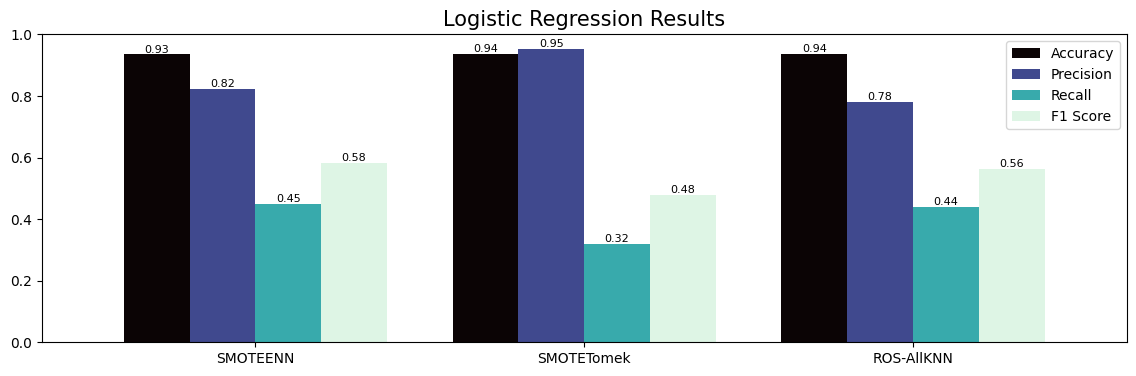

In [23]:
resplot(lrres, 'Logistic Regression Results')

In [24]:
cmm

[array([[3449,   38],
        [ 214,  175]], dtype=int64),
 array([[8040,   13],
        [ 562,  263]], dtype=int64),
 array([[3057,   39],
        [ 179,  140]], dtype=int64)]

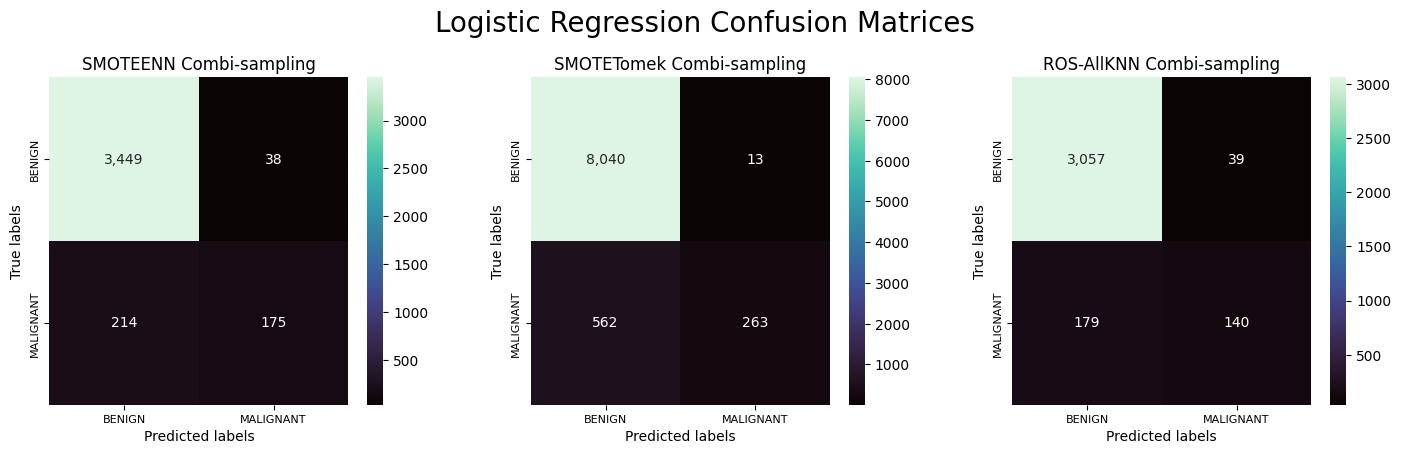

In [25]:
plot_confusion_grid(0,0, cm= cmm, t= 'Logistic Regression Confusion Matrices')

In [26]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'LGR CM with {cst[n]} combi-sampling', cm=i)


## Decision Tree Classifier

In [27]:
cmm=[]
dtcres=[]
clf = DecisionTreeClassifier()
for i in cst:
    clf = clf.fit(x_train[i],y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i],y_pred))
    dtcres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i],y_pred))
    # print(i+" Combi-sampling :")
    # drep['DTC']= report(y_test[i], y_pred)
    # print("\n")
cmd['DTC']=cmm

In [28]:
dtcres= pd.DataFrame(dtcres)
dtcres.index= cstindex
dtcres.columns= metric
dtcres

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.924665,0.612009,0.681234,0.644769
SMOTETomek,0.945483,0.694413,0.738182,0.715629
ROS-AllKNN,0.957540,0.719697,0.893417,0.797203


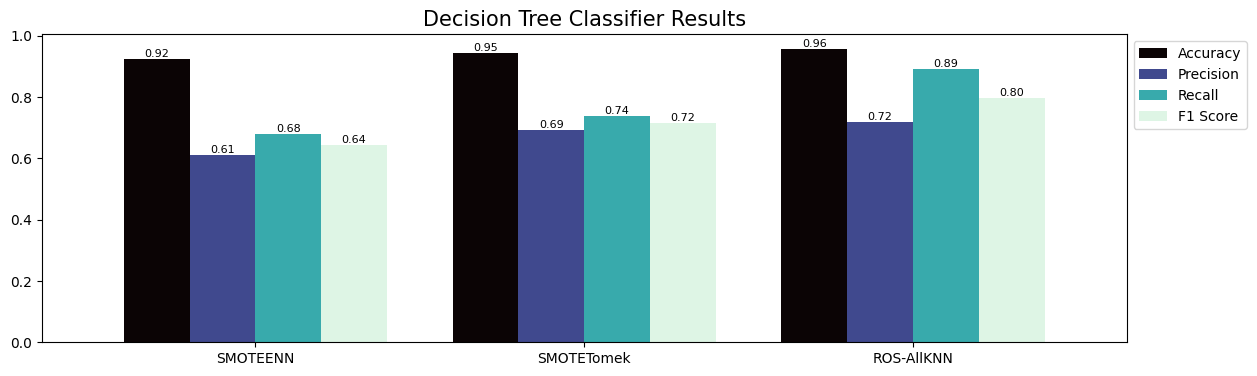

In [29]:
resplot(dtcres, 'Decision Tree Classifier Results')

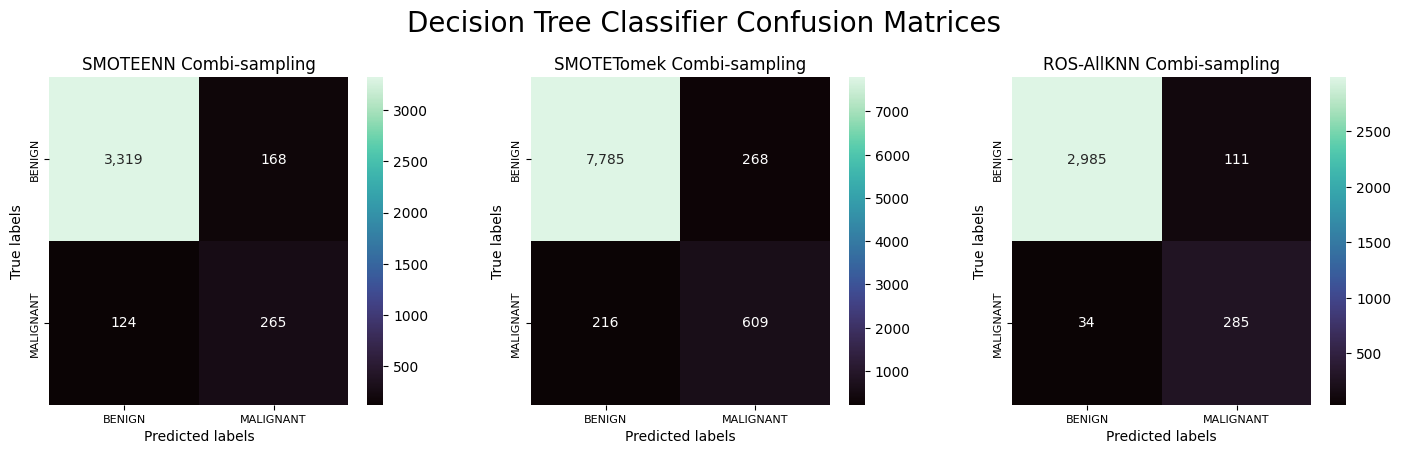

In [30]:
plot_confusion_grid(0,0,cm=  cmm, t= 'Decision Tree Classifier Confusion Matrices')

In [31]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'DTC CM with {cst[n]} combi-sampling', cm=i)


<h1> KNeighbors Classifier <hq>

In [32]:
from sklearn.neighbors import KNeighborsClassifier 
clf = KNeighborsClassifier(n_neighbors=3)
knnres=[]
cmm=[]
for i in cst:
    clf = clf.fit(x_train[i],y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i],y_pred))
    knnres.append(report1(y_test[i], y_pred))
    # print(i+" combi-sampling :")
    # drep['KNN']= report(y_test[i], y_pred)
    # print("\n\n")
cmd['KNN']=cmm

In [33]:
knnres= pd.DataFrame(knnres)
knnres.index= cstindex
knnres.columns= metric
knnres

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.941176,0.697789,0.730077,0.713568
SMOTETomek,0.941879,0.663147,0.761212,0.708804
ROS-AllKNN,0.952855,0.756494,0.730408,0.743222


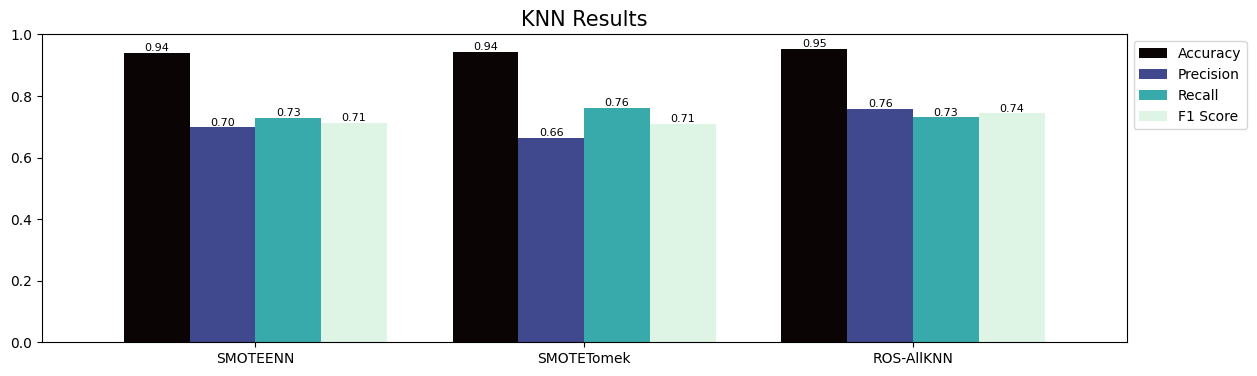

In [34]:
resplot(knnres, 'KNN Results')

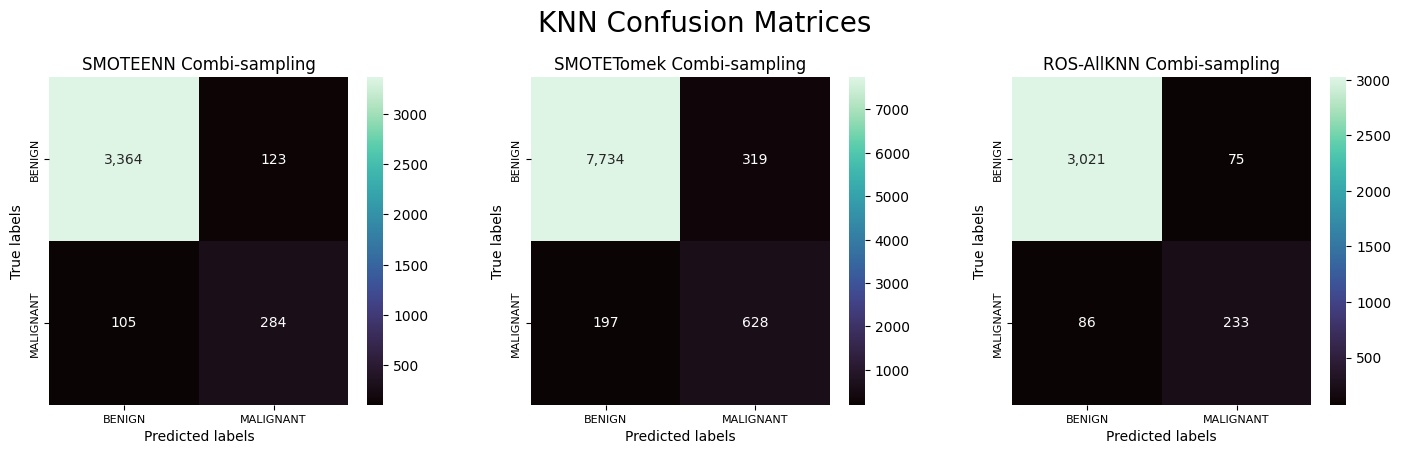

In [35]:
plot_confusion_grid(0,0,cm=  cmm, t= 'KNN Confusion Matrices')

In [36]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'KNN CM with {cst[n]} combisampling', cm=i)a

## Support Vector Classifier

In [37]:
cmm=[]
clf= SVC()
svmres=[]
for i in cst:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    svmres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" combi-sampling :")
    # drep['SVC']=report(y_test[i], y_pred)
    # print("\n")
cmd['SVC']=cmm


In [38]:
svmres= pd.DataFrame(svmres)
svmres.index= cstindex
svmres.columns= metric
svmres

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.936533,0.845411,0.449871,0.587248
SMOTETomek,0.910340,0.837209,0.043636,0.082949
ROS-AllKNN,0.950220,0.870647,0.548589,0.673077


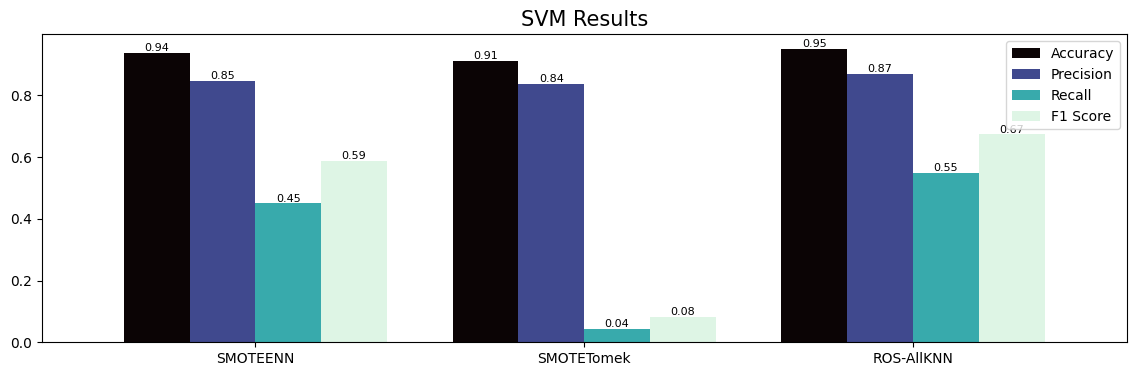

In [39]:
resplot(svmres, 'SVM Results')

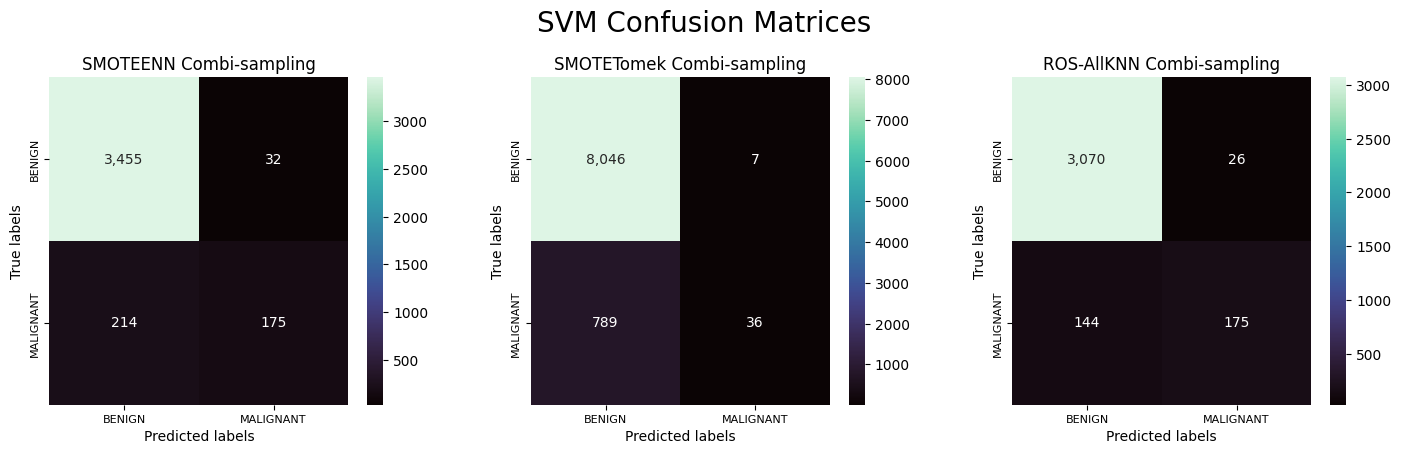

In [40]:
plot_confusion_grid(0,0,cm=  cmm, t= 'SVM Confusion Matrices')

In [41]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'SVM CM with {cst[n]} combi-sampling', cm=i)

## Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
cmm=[]
rfcres=[]
for i in cst:
    clf= RandomForestClassifier(n_estimators=200, criterion='gini')
    clf=clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    rfcres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" combi-sampling :")
    # drep['RFC']= report(y_test[i], y_pred)
    # print("\n")
cmd['RFC']=cmm

In [43]:
rfcres= pd.DataFrame(rfcres)
rfcres.index= cstindex
rfcres.columns= metric
rfcres

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.960526,0.933824,0.652956,0.768533
SMOTETomek,0.957873,0.987041,0.553939,0.709627
ROS-AllKNN,0.987994,0.963333,0.905956,0.933764


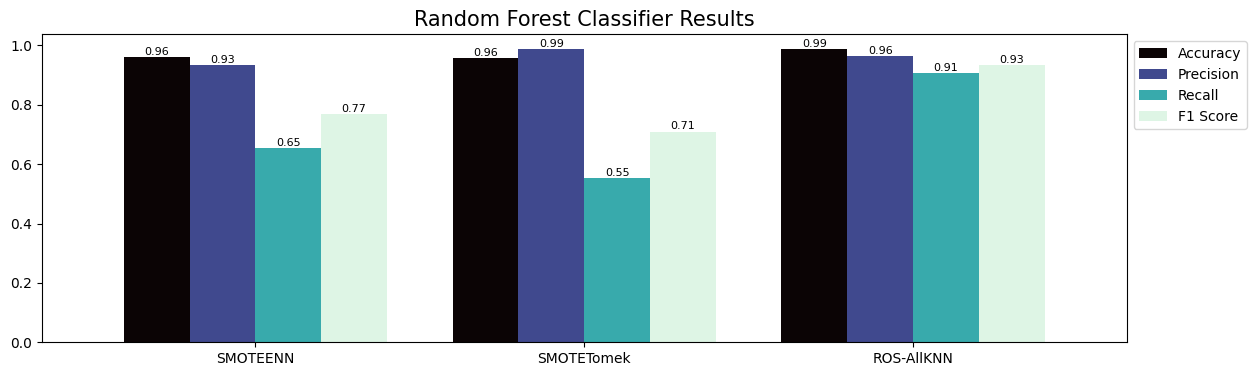

In [44]:
resplot(rfcres, 'Random Forest Classifier Results')

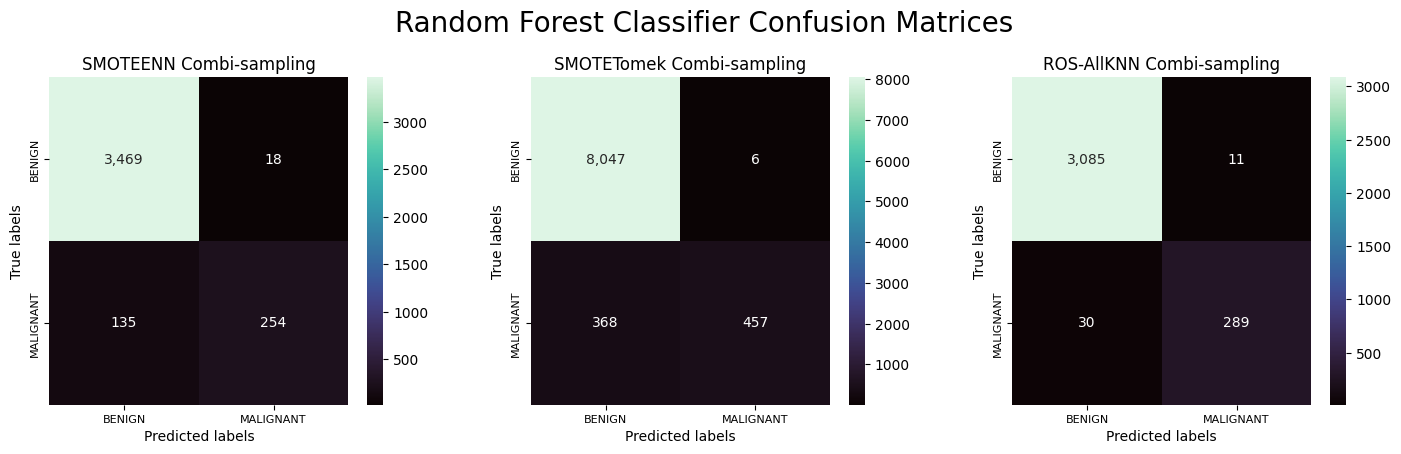

In [45]:
plot_confusion_grid(0,0,cm=  cmm, t= 'Random Forest Classifier Confusion Matrices')

In [46]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'RFC CM with {cst[n]} combi-sampling', cm=i)
    

## XG Boost Classifier

In [47]:
from xgboost import XGBClassifier
cmm=[]
xgbres=[]
for i in cst:
    clf = XGBClassifier()
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    xgbres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" combi-sampling :")
    # drep['XGB']=report(y_test[i], y_pred)
    # print("\n")
cmd['XGB']=cmm

In [48]:
xgbres= pd.DataFrame(xgbres)
xgbres.index= cstindex
xgbres.columns= metric
xgbres

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.969556,0.935691,0.748072,0.831429
SMOTETomek,0.981415,0.995495,0.803636,0.889336
ROS-AllKNN,0.987994,0.957237,0.912226,0.934189


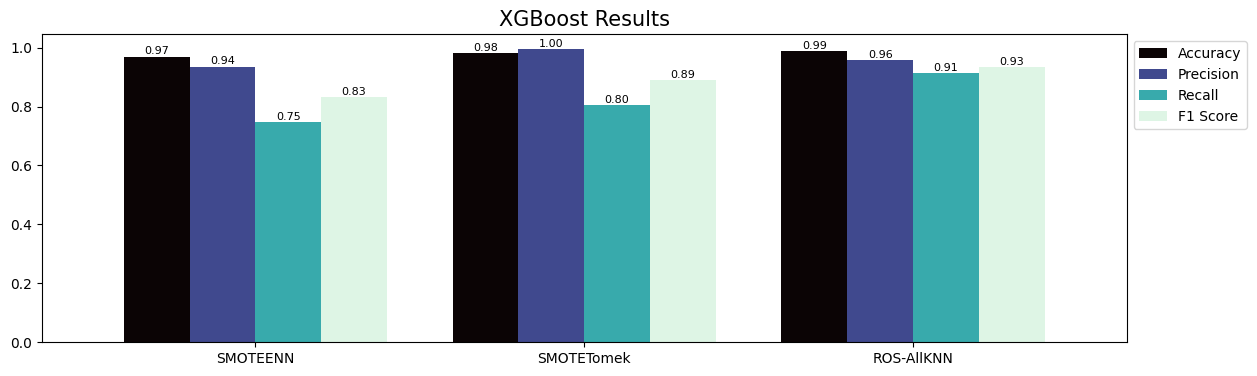

In [49]:
resplot(xgbres, 'XGBoost Results')

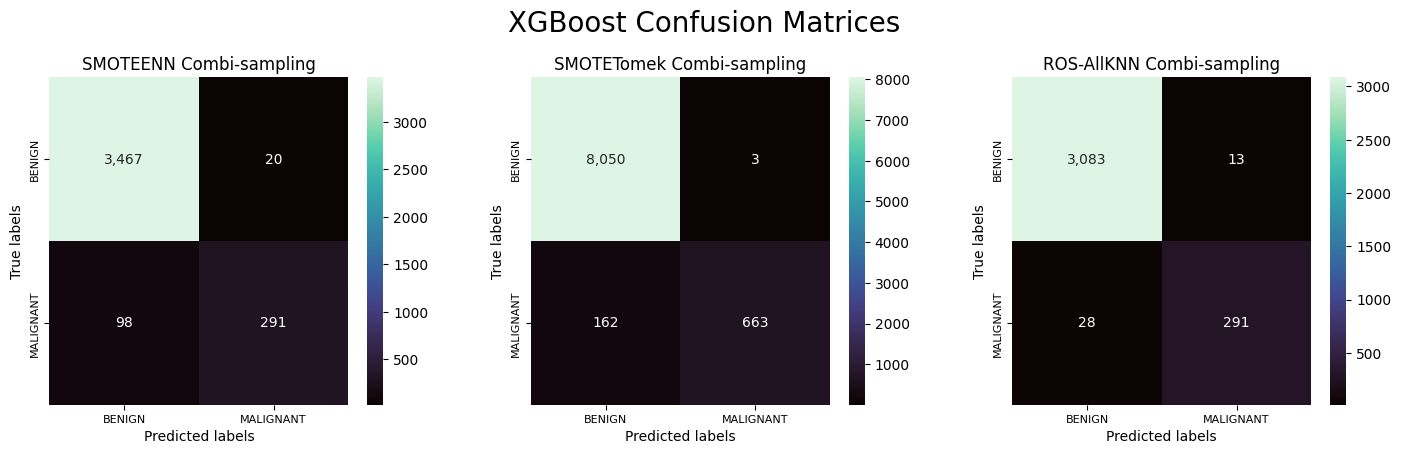

In [50]:
plot_confusion_grid(0,0,cm=  cmm, t= 'XGBoost Confusion Matrices')

In [51]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'XGBC CM with {cst[n]} combi-sampling', cm=i)


## Light GBM Classifier

In [52]:
from lightgbm import LGBMClassifier
cmm=[]
clf = LGBMClassifier(learning_rate=0.25, n_estimators=100, num_leaves=100)
lgbmres=[]
for i in cst:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    lgbmres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred)) 
    # print(i+" combi-sampling :")
    # drep['LGBM']=report(y_test[i], y_pred)
    # print("\n")
cmd['LGBM']=cmm

In [53]:
lgbmres= pd.DataFrame(lgbmres)
lgbmres.index= cstindex
lgbmres.columns= metric
lgbmres

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.976006,0.971338,0.784062,0.867710
SMOTETomek,0.981978,0.989691,0.814545,0.893617
ROS-AllKNN,0.990044,0.973422,0.918495,0.945161


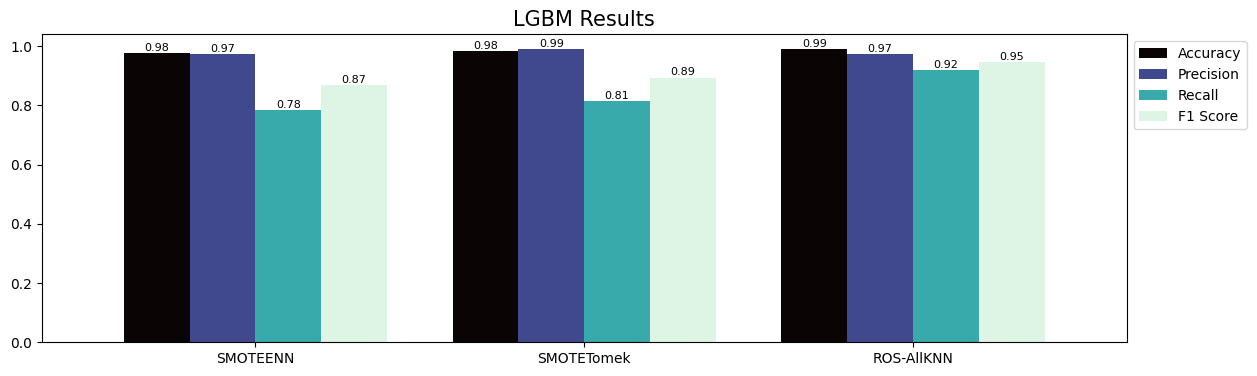

In [54]:
resplot(lgbmres, 'LGBM Results')

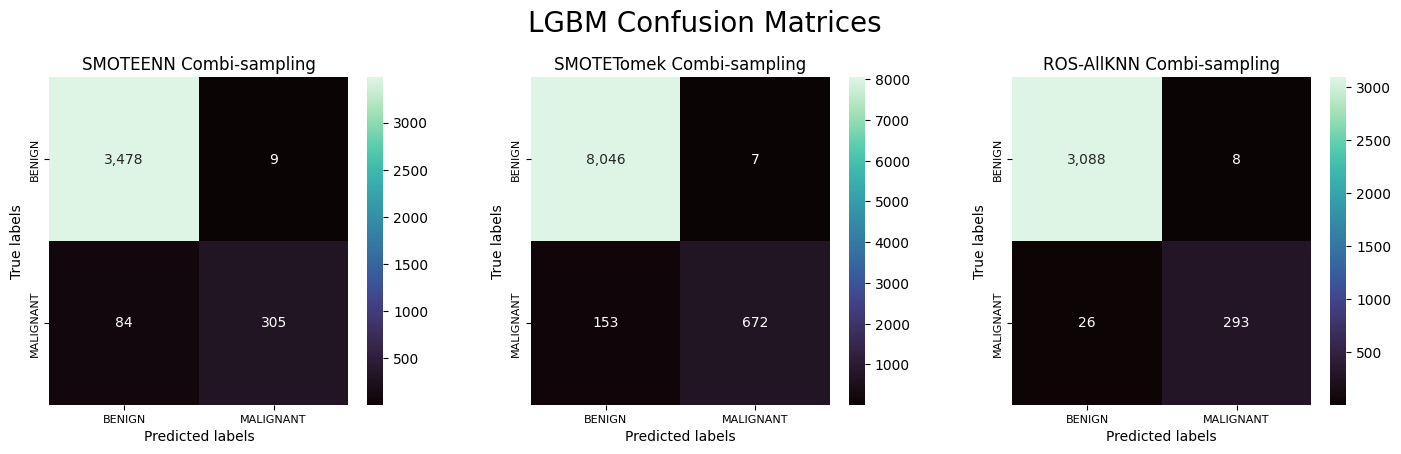

In [55]:
plot_confusion_grid(0,0,cm=  cmm, t= 'LGBM Confusion Matrices')

In [56]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'LGBM CM with {cst[n]} combisampling', cm=i)


## AdaBoost Classifier

In [57]:
from sklearn.ensemble import AdaBoostClassifier
cmm = []
adares=[]
tr= DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(estimator= tr, n_estimators=200, learning_rate=0.1, random_state=0)
for i in cst:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    adares.append(report1(y_test[i], y_pred))
    # drep['AdaB'] = print(confusion_matrix(y_test[i], y_pred))
    # print(i+" combisampling :")
    # report(y_test[i], y_pred)
    # print("\n")
cmd['AdaB']=cmm

In [58]:
adares= pd.DataFrame(adares)
adares.index= cstindex
adares.columns= metric
adares

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.968524,0.949495,0.724936,0.822157
SMOTETomek,0.979387,0.983434,0.791515,0.877099
ROS-AllKNN,0.990630,0.976744,0.921630,0.948387


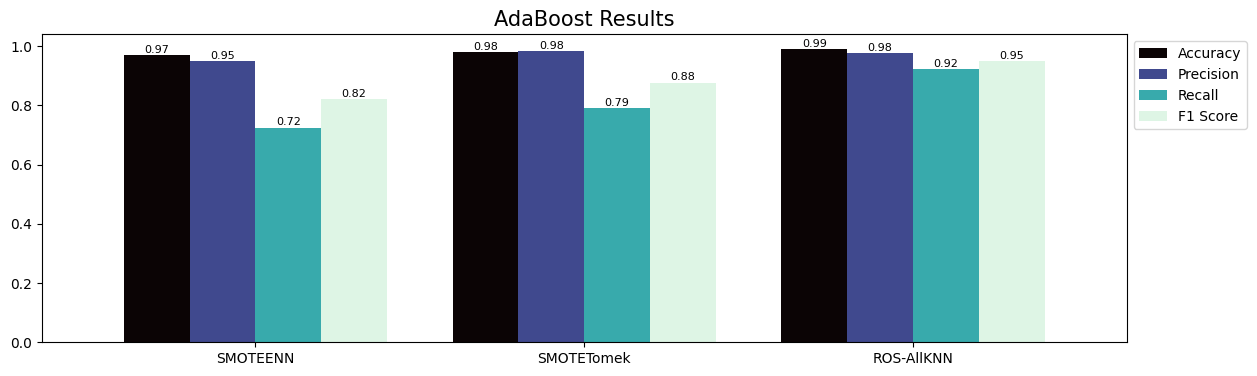

In [59]:
resplot(adares, 'AdaBoost Results')

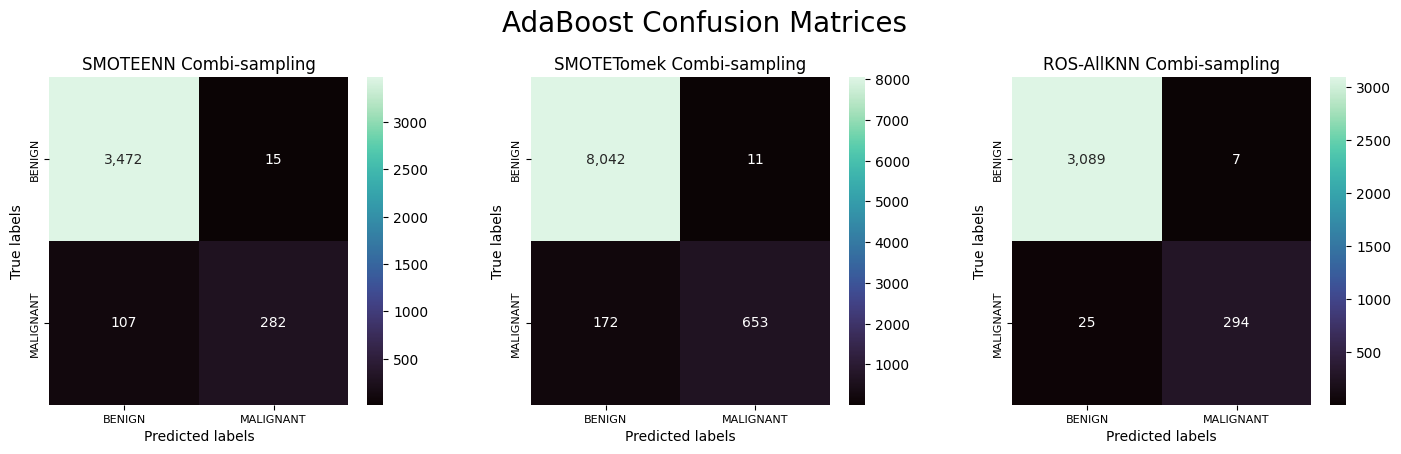

In [60]:
plot_confusion_grid(0,0,cm=  cmm, t= 'AdaBoost Confusion Matrices')

In [61]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'AdaBoost CM with {cst[n]} combi-sampling', cm=i)

## CatBoost Classifier

In [62]:
from catboost import CatBoostClassifier as CBC
cmm=[]
cbcres=[]
clf= CBC(learning_rate=0.1)
for i in cst:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    cbcres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" combisampling :")
    # drep['CB'] = report(y_test[i], y_pred)
    # print("\n")
cmd['CB']=cmm

0:	learn: 0.5835192	total: 143ms	remaining: 2m 22s
1:	learn: 0.4969076	total: 154ms	remaining: 1m 16s
2:	learn: 0.4375759	total: 164ms	remaining: 54.5s
3:	learn: 0.3946627	total: 175ms	remaining: 43.5s
4:	learn: 0.3565066	total: 185ms	remaining: 36.9s
5:	learn: 0.3267626	total: 197ms	remaining: 32.6s
6:	learn: 0.3047090	total: 208ms	remaining: 29.5s
7:	learn: 0.2858677	total: 219ms	remaining: 27.2s
8:	learn: 0.2746774	total: 230ms	remaining: 25.4s
9:	learn: 0.2637751	total: 242ms	remaining: 23.9s
10:	learn: 0.2546755	total: 253ms	remaining: 22.7s
11:	learn: 0.2455063	total: 263ms	remaining: 21.7s
12:	learn: 0.2399346	total: 275ms	remaining: 20.9s
13:	learn: 0.2330869	total: 287ms	remaining: 20.2s
14:	learn: 0.2263978	total: 298ms	remaining: 19.6s
15:	learn: 0.2231798	total: 309ms	remaining: 19s
16:	learn: 0.2197543	total: 321ms	remaining: 18.6s
17:	learn: 0.2152523	total: 332ms	remaining: 18.1s
18:	learn: 0.2103528	total: 344ms	remaining: 17.8s
19:	learn: 0.2067937	total: 357ms	remaini

In [63]:
cbcres= pd.DataFrame(cbcres)
cbcres.index= cstindex
cbcres.columns= metric
cbcres

,Accuracy,Precision,Recall,F1 Score
SMOTEENN,0.973168,0.961165,0.763496,0.851003
SMOTETomek,0.981302,0.989599,0.807273,0.889186
ROS-AllKNN,0.990044,0.961165,0.931034,0.945860


In [64]:
# for n,i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'CBC CM with {cst[n]} combi-sampling', cm=i)

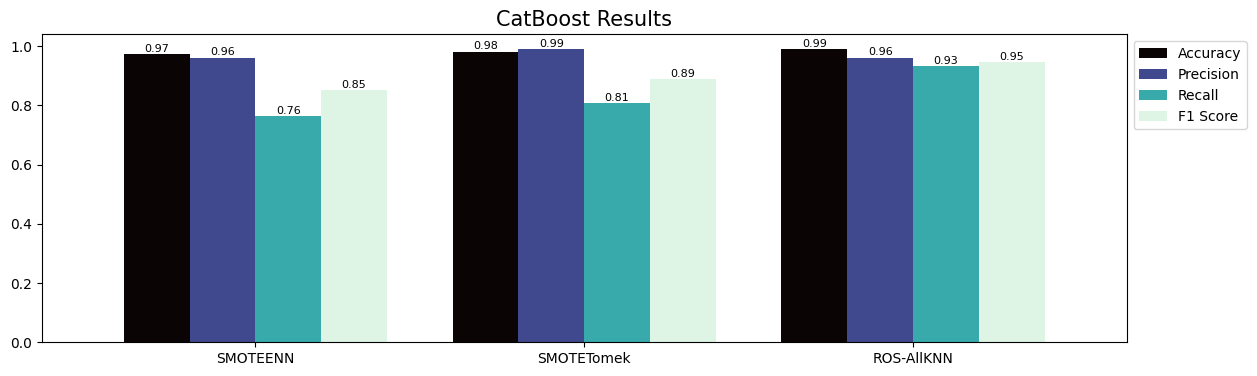

In [65]:
resplot(cbcres, 'CatBoost Results')

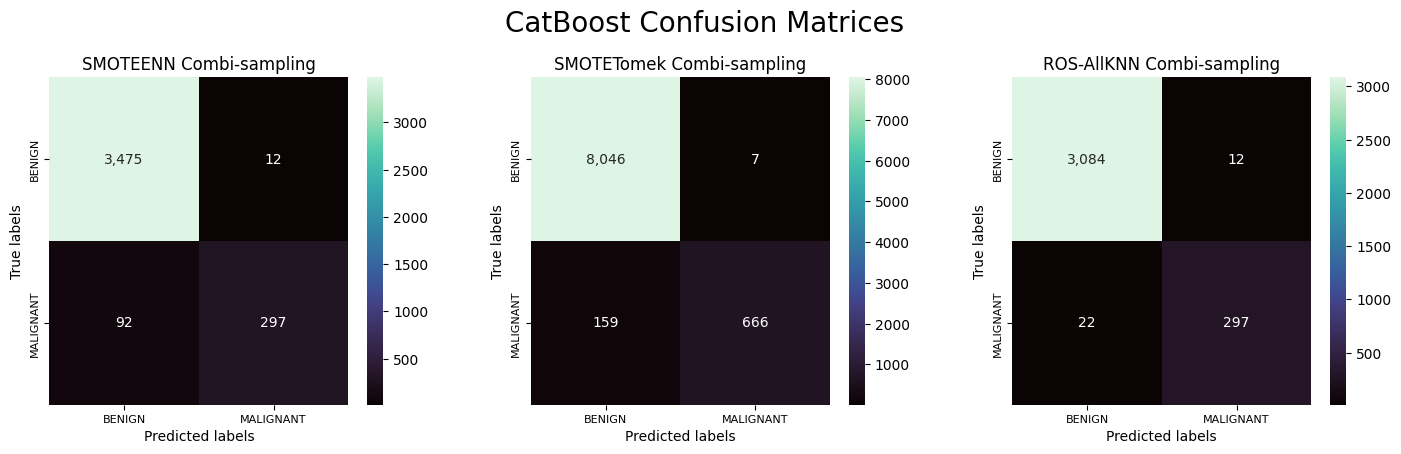

In [66]:
plot_confusion_grid(0,0,cm=  cmm, t= 'CatBoost Confusion Matrices')

In [67]:
# for i in cst:
#     print(i, x_train[i].shape, x_test[i].shape,
#           y_train[i].shape, y_test[i].shape)
#     print(Counter(y_train[i]), Counter(y_test[i]), "\n\n")


In [68]:
# for i in drep.keys():
#     print(i)
#     print(drep[i])
#     print(cmd[i])
#     print()

# Conclusion
1. The combination sampling as expected, performed very well for the ensemble learner classifiers, producing approx 0.9 F1 scores.
2. Smotetomek performed similar to basic smote oversampling there was almost no undersampling taking place because of Tomeklinks, and hence the no of samples were huge. 
3. Combining the best sampling methods for oversampling and undersampling, we can get the best results. And the best results were produced by manually combining the ROS and the AllKNN techniques. 
   